In [32]:
import sys
sys.path.insert(0, '../casadi_f16')
import f16

In [33]:
!pip install casadi

In [34]:
p = f16.Parameters()
x0, u0 = f16.trim(s0=[0, 0, 0, 0, 0, 0], x=f16.State(
    VT=502), p=p,
    phi_dot=0, theta_dot=0, psi_dot=0.3, gam=0)

               t_proc [s]   t_wall [s]    n_eval
           S       0.0189       0.0189         1
       nlp_f      0.00201      0.00202        54
  nlp_grad_f      0.00177      0.00177        19
  nlp_hess_l      0.00568      0.00569        17


In [35]:
x0

State(VT=502, alpha=DM(0.239262), beta=DM(0.00049257), phi=DM(1.36629), theta=DM(0.0500367), psi=0, P=DM(-0.0150048), Q=DM(0.29338), R=DM(0.0608502), p_N=0, p_E=0, alt=0, power=DM(64.1274))

In [36]:
u0

Control(thtl=DM(0.834978), ail_deg=DM(0.0963471), elv_deg=DM(-1.48177), rdr_deg=DM(-0.413878))

In [46]:
res  = f16.simulate(x0=x0, u0=u0, p=p, t0=0, tf=30, dt=0.01)

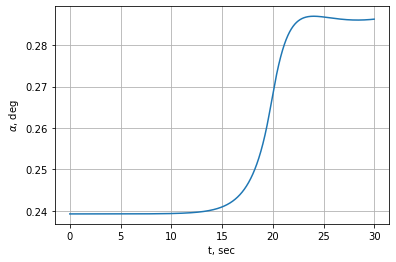

In [47]:
import matplotlib.pyplot as plt

plt.plot(res['t'], res['x'][:, f16.State().name_to_index('alpha')])
plt.xlabel('t, sec')
plt.ylabel(r'$\alpha$, deg')
plt.grid()

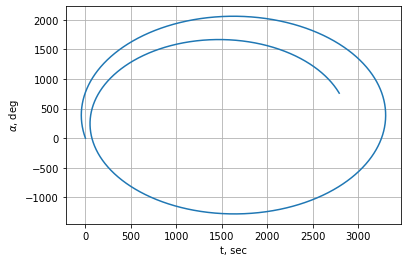

In [48]:
plt.plot(res['x'][:, f16.State().name_to_index('p_E')],
    res['x'][:, f16.State().name_to_index('p_N')])
plt.xlabel('t, sec')
plt.ylabel(r'$\alpha$, deg')
plt.grid()

In [51]:
ss = f16.linearize(x0, u0, p)
ss

A:
[[-8.71595160e-02 -1.67348624e+02  3.14139741e+01 -7.45240498e+00
  -3.12926713e+01  0.00000000e+00  4.86394347e-04 -7.45512773e+00
   2.01584684e-03  0.00000000e+00  0.00000000e+00  1.03150292e-04
   3.19208314e-01]
 [-5.36645843e-04 -1.05205750e+00  2.72967225e-04 -6.08843994e-02
   1.45355324e-02  0.00000000e+00 -4.78537796e-04  9.03080261e-01
  -1.16732105e-04  0.00000000e+00  0.00000000e+00  8.87810164e-06
  -1.55111735e-04]
 [-1.25677941e-04  1.23986814e-04 -3.22015239e-01  1.30056500e-02
  -3.10769925e-03  0.00000000e+00  2.38953072e-01  7.31507819e-06
  -9.63360648e-01  0.00000000e+00  0.00000000e+00 -1.87597100e-10
  -3.13211773e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.47489529e-19
   3.00375943e-01  0.00000000e+00  1.00000000e+00  4.90349067e-02
   1.01703473e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.99624527e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  2.03088022e-

In [60]:
import control
sub_ss = ss.sub_system(x=['VT', 'alpha'], u=['ail_deg'], y=['VT']).to_control()
sub_ss

A = [[-8.71595160e-02 -1.67348624e+02]
 [-5.36645843e-04 -1.05205750e+00]]

B = [[7.29599238e-05]
 [0.00000000e+00]]

C = [[1. 0.]]

D = [[0.]]

In [62]:
G1 = control.ss2tf(sub_ss)
G1


7.296e-05 s + 7.676e-05
-----------------------
s^2 + 1.139 s + 0.00189

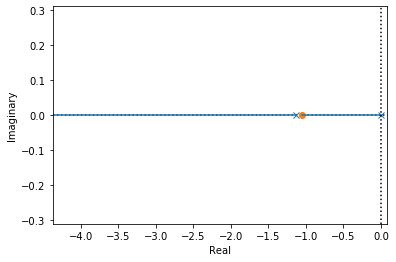

In [64]:
control.rlocus(G1);

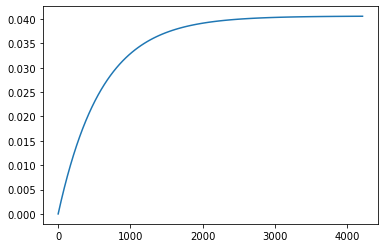

In [66]:
t, y = control.step_response(G1)
plt.plot(t, y)

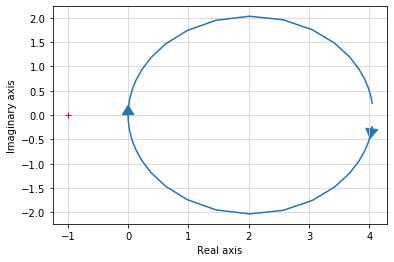

In [79]:
control.nyquist(100*G1);

In [71]:
control.pole(G1)

array([-1.13755567, -0.00166135])

In [72]:
control.zero(G1)

array([-1.0520575])

In [73]:
import numpy as np

In [76]:
np.linalg.eig(ss.A)[0]

array([ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
        0.00000000e+00+0.j        , -9.09150830e-01+4.48721886j,
       -9.09150830e-01-4.48721886j, -2.96709912e+00+0.j        ,
       -2.22720190e+00+0.j        ,  5.76181038e-01+0.j        ,
       -2.93081610e-03+0.30641764j, -2.93081610e-03-0.30641764j,
       -8.25335919e-02+0.j        , -9.13816963e-04+0.j        ,
       -5.00000000e+00+0.j        ])